#### Authorship

Created by Shawn Tan (banchan@gmail.com) for DJ BambahMukku Lab

#### Changelog

2/24/25 - Added imports and loading of face_rhythm data, as well as raw displacement over time.

#### Description
- Processes bonsai output for stimuli alignment.
- Analyzes face_rhythm data

#### Instructions
- Install face_rhythm (this script calls on some functions from there)
- Install seaborn (plotting library)
- `conda activate face_rhythm`
- `jupyter notebook`

#### Project organization
- face_rhythm folder (clone modified repository https://github.com/banchan86/face-rhythm-DJ)
- airpuff data folder
  - experimental day folder
    - subject ID folder
      - bonsai output
      - facerhythm output

# Imports

In [5]:
import seaborn as sns
import face_rhythm as fr
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Individual Session Analysis

# Load session data

In [7]:
# Define constants for folder location
data_folder = "Airpuff_Data"
experiment_day = "02_18_25_Pilot_WT_P2"
subjectID = "pilot4-WT-P4_female"

In [16]:
session_folder = str(Path("../").resolve() / data_folder / experiment_day / subjectID)


In [17]:
print(session_folder)

C:\Users\shawn\Desktop\face-rhythm-DJ\Airpuff_Data\02_18_25_Pilot_WT_P2\pilot4-WT-P4_female


# Generate Airpuff stimulus framestamps

# Plot frame by frame displacement

In [ ]:
raw_data = fr.h5_handling.simple_load("analysis_files\\PointTracker.h5")

In [73]:
# Compute displacement: difference between consecutive frames
delta = np.diff(raw_data["points_tracked"]["0"], axis = 0) # Shape: (33484, 185, 2) (One less frame)

In [74]:
# Compute Euclidean distance for each point
displacement = np.linalg.norm(delta, axis=2)  # Shape: (33484, 185)

In [77]:
# Compute mean displacement across all points
mean_displacement = np.mean(displacement, axis=1)  # Shape: (33484,)

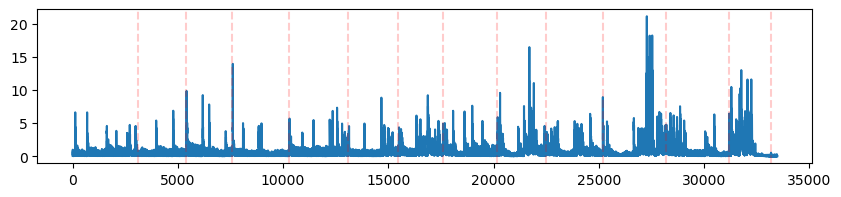

In [94]:
# plot mean displacement over time
plt.figure(figsize=(10, 2))
sns.lineplot(x = np.arange(33484), y=mean_displacement)

# overlay airpuffs
airpuffs = [3081, 5381, 7582, 10282, 13083, 15483, 17584, 20183, 22485, 25185, 28186, 31186, 33187]

for event in airpuffs:
    plt.axvline(x=event, color="red", linestyle="--", alpha=0.2, label=f"Event at {event}")

# Supplementary: Data inspection 

In [ ]:
# Shawn's notes 2/24/25
# I wrote this section to inspect the point tracking data produced by face-rhythm and write some notes.
# Doesnt need to be run (unless you run into some errors at some point and need to figure out what is wrong)
# key 1 - mask is a numpy.ndarray with a boolean value for every pixel in the (vertical video) x (horizontal video) frame. ROI
# key 2 - mesh_d0 is a numpy.ndarray that is the (number of points) x (x and y coords). unclear what it is
# key 3 - neighbors is a numpy.ndarray that is the (number of points) x (list of 40 neighbours), probably the index of the closest neighbours
# key 4 - point_positions is the (number of points) x (x and y coords). seem to be the initial mesh point position
# key 5 - points tracked is the motherload. its a (frame)x(number of points)x (x and y coords). 

In [ ]:
raw_data = fr.h5_handling.simple_load("analysis_files\\PointTracker.h5")

In [18]:
for key in raw_data.keys():
    print(key, type(raw_data[key]))

mask <class 'numpy.ndarray'>
mesh_d0 <class 'numpy.ndarray'>
neighbors <class 'numpy.ndarray'>
point_positions <class 'numpy.ndarray'>
points_tracked <class 'dict'>
violations <class 'dict'>


(750, 1440)


<Axes: >

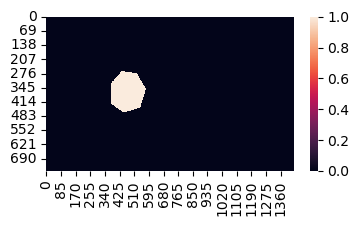

In [33]:
# mask visualization section
print(raw_data["mask"].shape)
plt.figure(figsize=(4, 2))
sns.heatmap(raw_data["mask"])

(185, 2)


<Axes: >

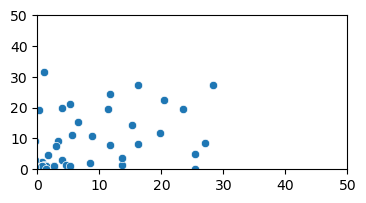

In [47]:
# mesh_d0 visualization section
print(raw_data["mesh_d0"].shape)
plt.figure(figsize=(4, 2))
plt.xlim(0, 50)
plt.ylim(0, 50)
sns.scatterplot(x = raw_data["mesh_d0"][:,0], y = raw_data["mesh_d0"][:,1], )

In [50]:
# neighbours visualization section
print(raw_data["neighbors"].shape)
print(raw_data["neighbors"])

(185, 40)
[[  0   1   9 ...  58  24  57]
 [  1   0   2 ...  49  60  61]
 [  2   1   3 ...  61  29  37]
 ...
 [182 173 181 ... 146 139 133]
 [183 174 182 ... 140 178 155]
 [184 180 181 ... 144 152 156]]


(185, 2)


<Axes: >

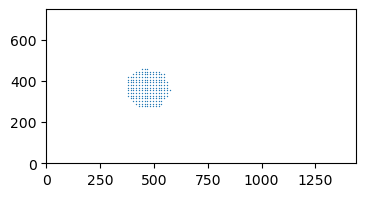

In [62]:
# point_positions visualization section
print(raw_data["point_positions"].shape)
plt.figure(figsize=(4, 2))
plt.xlim(0, 1440)
plt.ylim(0, 750)
sns.scatterplot(x = raw_data["point_positions"][:,0], y = raw_data["point_positions"][:,1], s =1)

In [82]:
# points_tracked visualization section
print(raw_data["points_tracked"]["0"].shape)

(33485, 185, 2)


In [89]:
print(raw_data["violations"]["0"])

{'col': array([ 16,  25,  26, ..., 151, 152, 153]), 'data': array([ True,  True,  True, ...,  True,  True,  True]), 'row': array([21548, 21548, 21548, ..., 31760, 31760, 31760]), 'shape': array([33485,   185])}
